# FinOps AWS Forecasting
## Using Timeseries
### Author: Jorge Rodriguez
### Date: Feb-2025

In [2]:
import boto3
from datetime import date
from dateutil.relativedelta import relativedelta
import seaborn as sns
import pandas as pd
import subprocess
from time import time, sleep
import webbrowser
from boto3.session import Session
import matplotlib.pyplot as plt
import glob

import numpy as np
import seasonal
%matplotlib inline

from matplotlib import ticker

import xgboost as xgb
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import xgboost as xgb # brew install libomp
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

from statsmodels.tsa.filters.hp_filter import hpfilter

from prophet import Prophet
from prophet.plot import plot, plot_components



/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


/var/folders/bc/rbbb9nc96zd3bj2l2mq3klq00000gp/T/ipykernel_48411/337873197.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  combined_df['Month No'] = combined_df['Month'].replace(month_name,month_number)


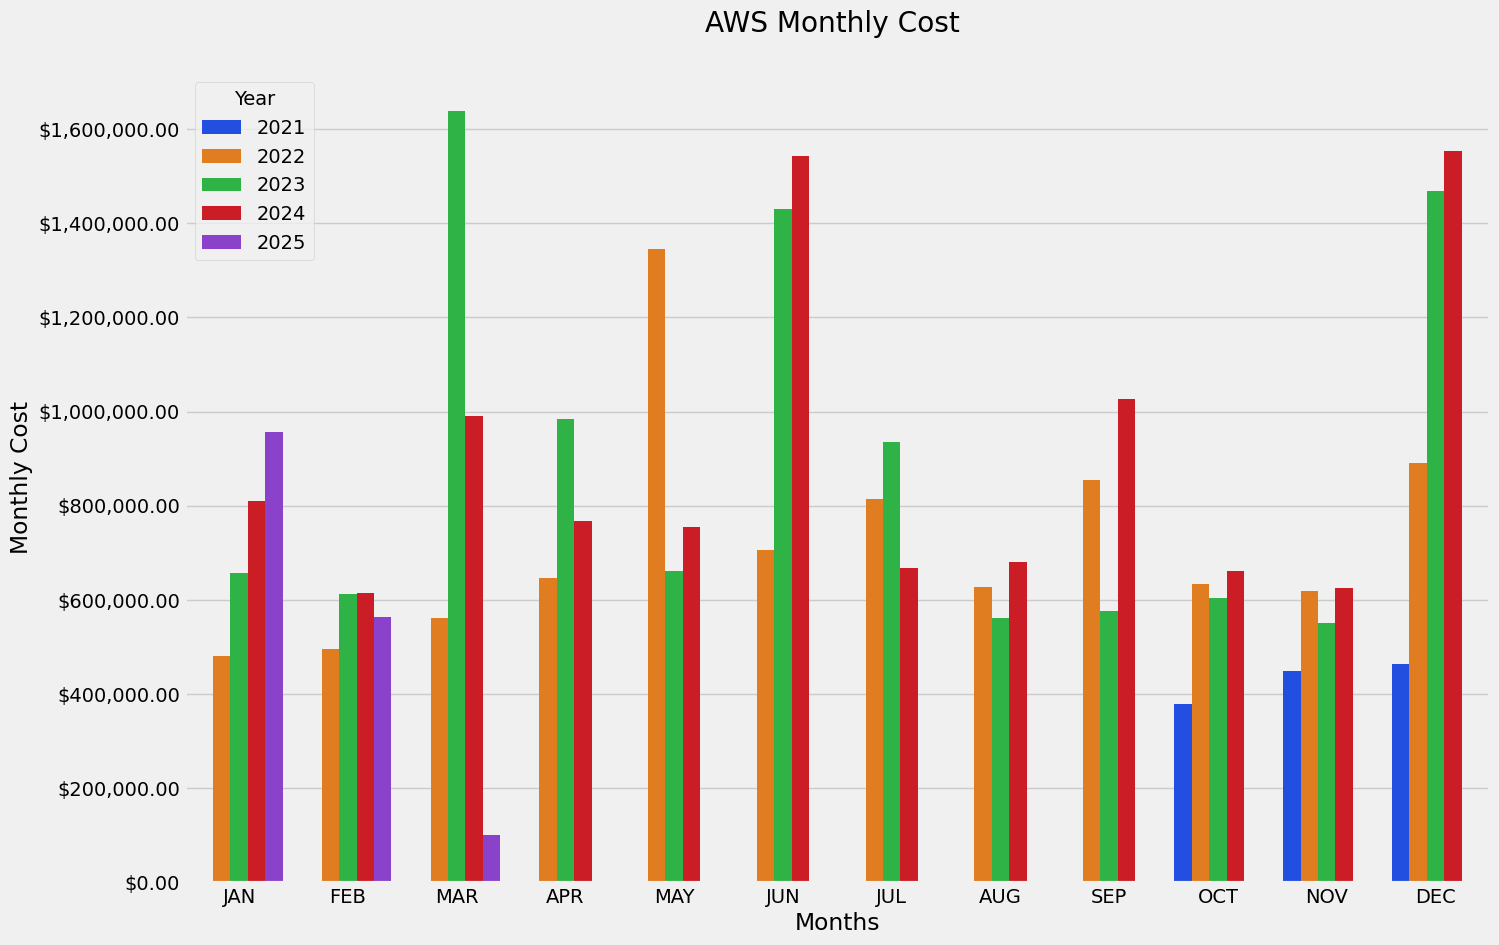

In [3]:
# Get a list of all CSV files in the directory
csv_files = glob.glob('Monthly_Cost_For_*.csv')

# Create an empty list to store the DataFrames
dfs = [] 

# Loop over each CSV file and read it into a DataFrame
for file in csv_files:
    #print("reading File: " + file)
    df = pd.read_csv(file) 
    dfs.append(df) 

# Concatenate all the DataFrames into one
combined_df = pd.concat(dfs, axis=0, ignore_index=True) 
month_name = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
month_number = [1,2,3,4,5,6,7,8,9,10,11,12]
kafka_new ='Apache Kafka® & Apache Flink® on Confluent Cloud™ - Annual Commits'
kafka_old ='Apache Kafka® on Confluent Cloud™ - Annual Commits'
combined_df['Month No'] = combined_df['Month'].replace(month_name,month_number)
combined_df['Service'] = combined_df['Service'].replace('Datadog Pro','Datadog')
combined_df['Service'] = combined_df['Service'].replace(kafka_old,kafka_new)

#otal_per_month_df = combined_df.groupby(['Year','Month','Month No']).agg({'Cost':'sum'}).sort_values(by='Month')
total_per_month_df = combined_df.groupby(['Year','Month','Month No']).agg(Total_cost_per_Month=('Cost','sum')).sort_values(by='Month No')
total_per_month_df['Cost_in_Millions'] = total_per_month_df['Total_cost_per_Month']/1000


# Initialize the matplotlib figure
#sns.color_palette("viridis", as_cmap=True)
sns.color_palette("bright")
fig, ax = plt.subplots(figsize=(15, 10))

sns.barplot(x="Month", y="Total_cost_per_Month", data=total_per_month_df,
            hue='Year', legend=True, color='green',palette='bright')


# Add a legend and informative axis label
#ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set_xlabel("Months")
ax.set_ylabel("Monthly Cost")
ax.set_title("AWS Monthly Cost \n")
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "${:,.2f}".format(int(x))))
plt.show()




# Time Series Exploration 

In [4]:
splite_date = '02-01-2024'### (M-D-Y) 12 months before the last day of a full month we are on the calendar year. <March> 
last_date = '03-01-2025' ### <March> and will keep moving as we move on the calendar

In [5]:
def create_features(df):
    '''
    Create time series features based on time series index
    '''
    df = df.copy()
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.day_of_week
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['quarter'] = df.index.quarter
    df['1_month_lag'] = df['Cost'].shift(1)
    df['2_month_lag'] = df['Cost'].shift(2)
    df['3_month_lag'] = df['Cost'].shift(3)
    #df['6_month_lag'] = df['Cost'].shift(6)
    #df['12_month_lag'] = df['Cost'].shift(12)
    #df['24_month_lag'] = df['Cost'].shift(24)
    #df['6_month_mean'] = df['Cost'].rolling(window = 6).mean()
    #df['12_month_mean'] = df['Cost'].rolling(window = 12).mean()
    #df['24_month_mean'] = df['Cost'].rolling(window = 24).mean()
    #df['6_month_std'] = df['Cost'].rolling(window = 6).std()
    #df['12_month_std'] = df['Cost'].rolling(window = 12).std()
    #df['24_month_std'] = df['Cost'].rolling(window = 24).std()
    #df['6_month_max'] = df['Cost'].rolling(window = 6).max()
    #df['12_month_max'] = df['Cost'].rolling(window = 12).max()
    #df['24_month_max'] = df['Cost'].rolling(window = 24).max()
    #df['6_month_min'] = df['Cost'].rolling(window = 6).min()
    #df['12_month_min'] = df['Cost'].rolling(window = 12).min()
    #df['24_month_min'] = df['Cost'].rolling(window = 24).min()
    return df

/var/folders/bc/rbbb9nc96zd3bj2l2mq3klq00000gp/T/ipykernel_48411/2856260813.py:6: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df_ml = df_ml.groupby(by=['Date']).agg({'Cost':sum})
/var/folders/bc/rbbb9nc96zd3bj2l2mq3klq00000gp/T/ipykernel_48411/2856260813.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['${:,}'.format(int(val)) for val in current_values])
/var/folders/bc/rbbb9nc96zd3bj2l2mq3klq00000gp/T/ipykernel_48411/2856260813.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['${:,}'.format(int(val)) for val in current_values])


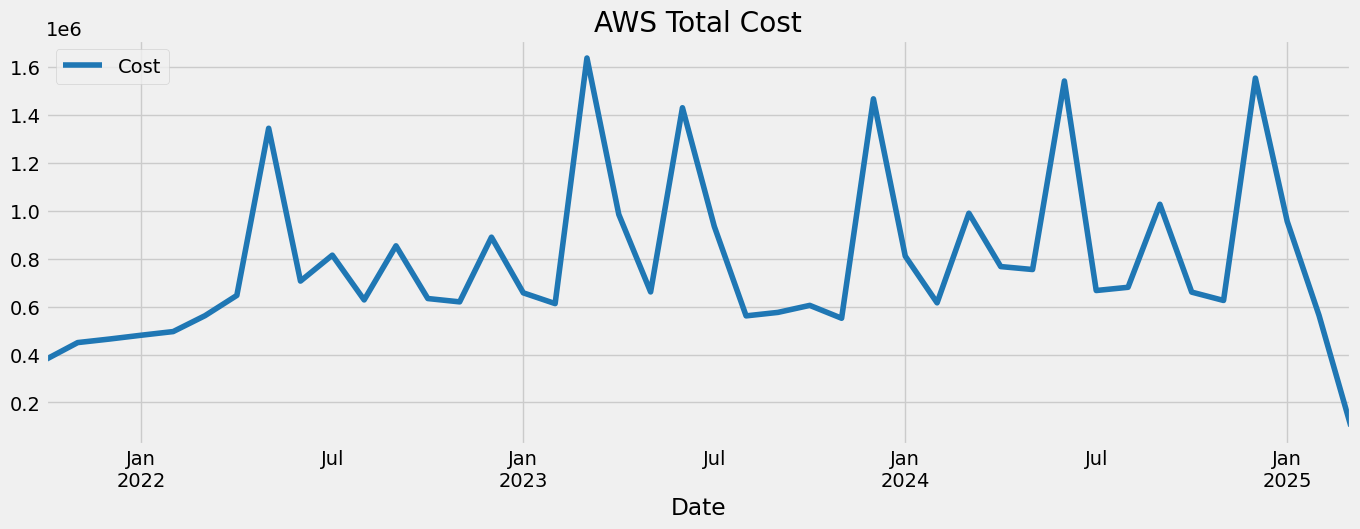

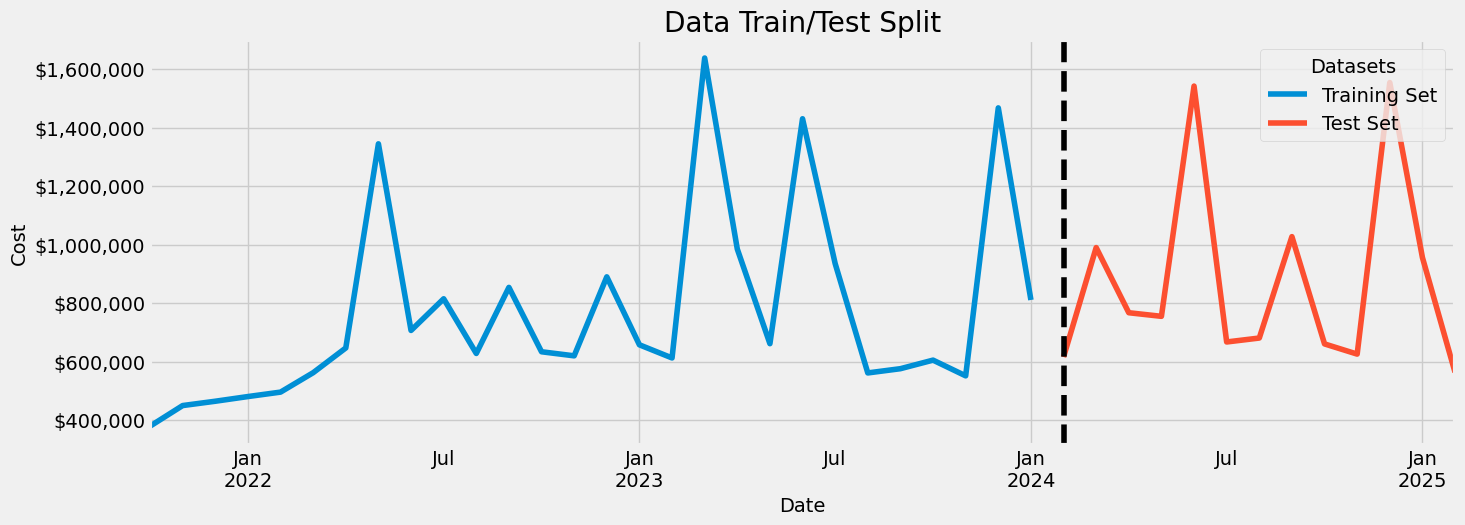

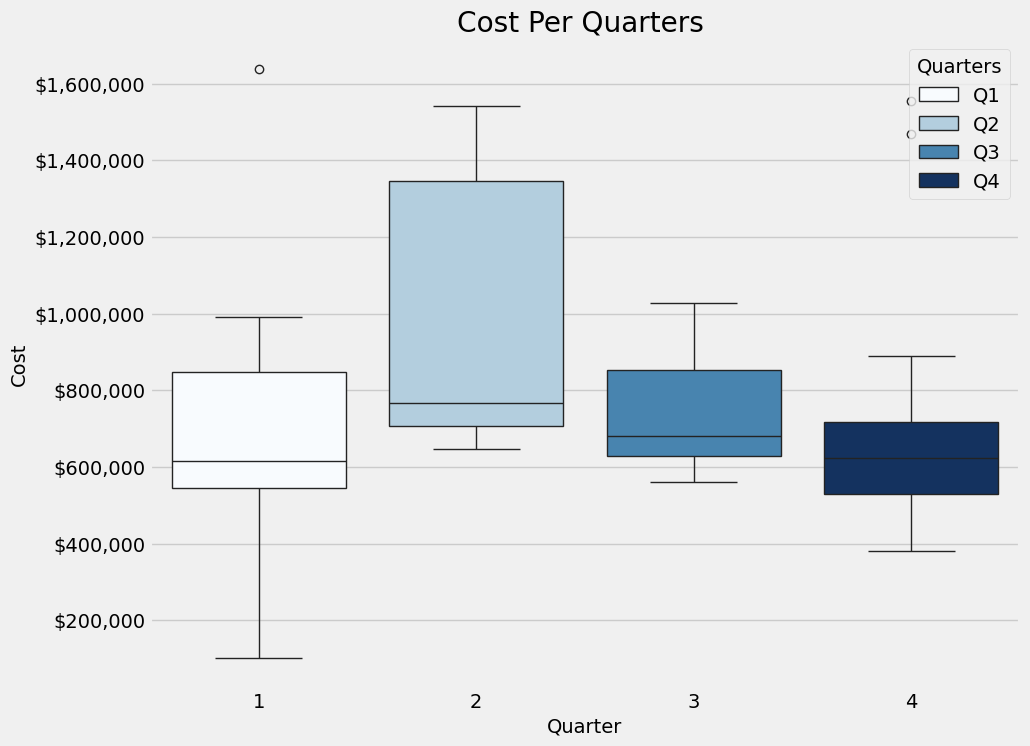

[0]	validation_0-rmse:323116.08910	validation_1-rmse:337657.81729
[100]	validation_0-rmse:248992.49966	validation_1-rmse:305956.65158
[200]	validation_0-rmse:192708.73023	validation_1-rmse:271169.25590
[300]	validation_0-rmse:158460.38408	validation_1-rmse:246795.14817
[400]	validation_0-rmse:132532.00491	validation_1-rmse:225878.42697
[500]	validation_0-rmse:110719.26277	validation_1-rmse:207290.47652
[600]	validation_0-rmse:94255.27531	validation_1-rmse:193870.77061
[700]	validation_0-rmse:80473.34971	validation_1-rmse:184700.98942
[800]	validation_0-rmse:69040.51748	validation_1-rmse:178647.90924
[900]	validation_0-rmse:58614.45866	validation_1-rmse:174924.61772
[1000]	validation_0-rmse:50308.72233	validation_1-rmse:171921.50498
[1074]	validation_0-rmse:44729.83951	validation_1-rmse:171752.75848


/var/folders/bc/rbbb9nc96zd3bj2l2mq3klq00000gp/T/ipykernel_48411/2856260813.py:83: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['${:,}'.format(int(val)) for val in current_values])


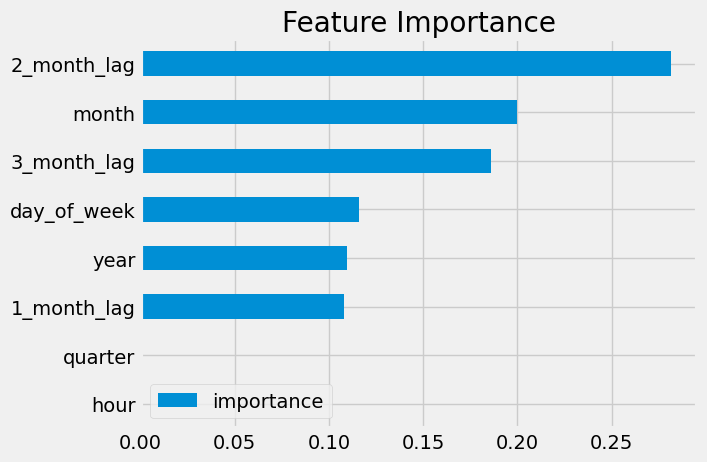

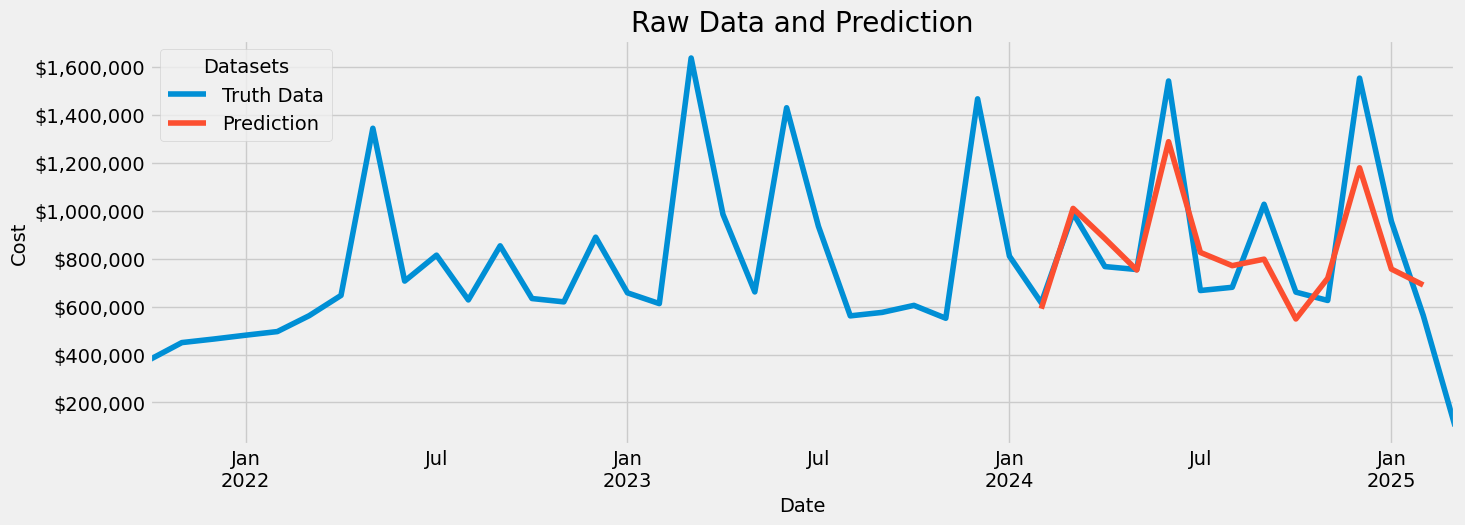

RMSE Score on Test Set: 171,409.91
RMSE Score on Test Set: 171,409.91


/var/folders/bc/rbbb9nc96zd3bj2l2mq3klq00000gp/T/ipykernel_48411/2856260813.py:108: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df_now = df_now.groupby(by=['Date']).agg({'Cost':sum})
/var/folders/bc/rbbb9nc96zd3bj2l2mq3klq00000gp/T/ipykernel_48411/2856260813.py:144: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['${:,}'.format(int(val)) for val in current_values])


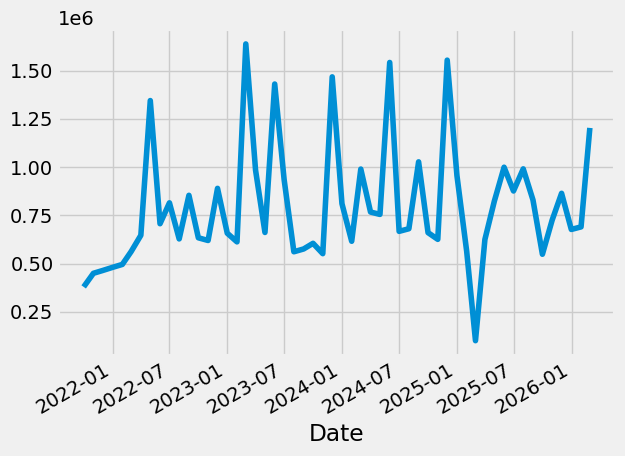

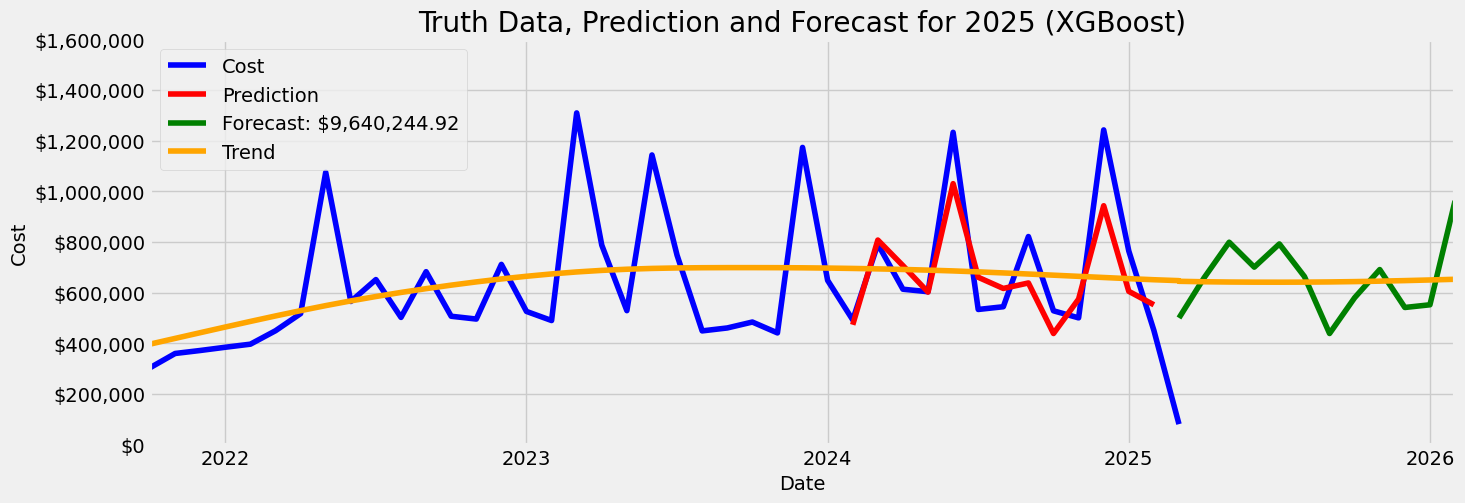

In [6]:
df_ml =combined_df.copy()
df_ml['Date_str'] = df_ml['Year'].apply(lambda x: str(x)) + "-" + df_ml['Month No'].apply(lambda x: str(x)) + "-01"
df_ml['Date'] = pd.to_datetime(df_ml['Date_str'])
df_ml.set_index('Date')
df_ml.index = pd.to_datetime(df_ml.index)
df_ml = df_ml.groupby(by=['Date']).agg({'Cost':sum})


df_ml.plot(style='-', figsize=(15,5), color=color_pal[0], title='AWS Total Cost')

#---------------------------------------------------------------------------------
train = df_ml.loc[df_ml.index < splite_date]
test = df_ml.loc[(df_ml.index >= splite_date) & (df_ml.index < last_date)]

fig, ax = plt.subplots(figsize=(15,5))
formatter = ticker.ScalarFormatter()
formatter.set_scientific(False)
ax.yaxis.set_major_formatter(formatter)
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label = 'Test Set')
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['${:,}'.format(int(val)) for val in current_values])
ax.axvline(splite_date, color='black', ls='--')
ax.set_xlabel("Date", fontsize=14)
ax.set_ylabel("Cost", fontsize=14)
ax.legend(['Training Set', 'Test Set'], loc='upper right', title='Datasets')


#---------------------------------------------------------------------------------
df_ml = create_features(df_ml)
fix, ax = plt.subplots(figsize=(10,8))
formatter = ticker.ScalarFormatter()
formatter.set_scientific(False)
ax.yaxis.set_major_formatter(formatter)
sns.boxplot(data=df_ml, x='quarter', y='Cost', palette='Blues', hue='quarter')
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['${:,}'.format(int(val)) for val in current_values])
ax.set_title('Cost Per Quarters ')
ax.legend(['Q1', 'Q2', 'Q3', 'Q4'], loc='upper right', title='Quarters')
ax.set_xlabel("Quarter", fontsize=14)
ax.set_ylabel("Cost", fontsize=14)
plt.show()

#---------------------------------------------------------------------------------
train = create_features(train)
test = create_features(test)

FEATURES = train.columns[1:]
TARGET = train.columns[0]

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

# regresion model
reg = XGBRegressor(n_estimators = 12000,
                   early_stopping_rounds = 40,
                   learning_rate=0.01,
                   max_depth=2,
                   random_state=42
                   )

#reg = xgb.XGBRegressor()

reg.fit(X_train, y_train,
        eval_set = [(X_train,y_train), (X_test, y_test)],
        verbose = 100)

fi = pd.DataFrame(data=reg.feature_importances_, index=reg.feature_names_in_,columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title="Feature Importance")

#---------------------------------------------------------------------------------
test['predictions'] = reg.predict(X_test)
df_ml1 = df_ml.merge(test[['predictions']], how='left', left_index=True, right_index=True)

ax = df_ml1[['Cost']].plot(figsize=(15,5))
formatter = ticker.ScalarFormatter()
formatter.set_scientific(False)
ax.yaxis.set_major_formatter(formatter)
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['${:,}'.format(int(val)) for val in current_values])
df_ml1['predictions'].plot(ax=ax, style='-')
ax.set_title('Raw Data and Prediction')
ax.legend(['Truth Data', 'Prediction'], loc='upper left', title='Datasets')
ax.set_xlabel("Date", fontsize=14)
ax.set_ylabel("Cost", fontsize=14)
plt.show()

score = np.sqrt(mean_squared_error(test['Cost'], test['predictions']))
print(f'RMSE Score on Test Set: {score:,.2f}')
num = "{:,.2f}".format(score)
print('RMSE Score on Test Set:', num)


#---------------------------------------------------------------------------------
from xgboost import XGBRegressor
model = XGBRegressor()

Cost = df_ml[-12:]['Cost'].values
Date_str = df_ml[-12:].index.values + pd.to_timedelta(52, 'W')
data = {'Date_str': Date_str,'Cost' : Cost}
df_now = pd.DataFrame(data)
df_now['Date'] = pd.to_datetime(df_now['Date_str'])
df_now.set_index('Date')
df_now.index = pd.to_datetime(df_now.index)
df_now = df_now.groupby(by=['Date']).agg({'Cost':sum})
df_now = create_features(df_now)
df_now.drop('Cost', axis=1, inplace=True)
df_now['predictions'] = reg.predict(df_now)

df_new = pd.DataFrame()
df1_date =  df_ml.index.values
df1_date = np.append(df1_date, df_now.index.values)
df1_cost = df_ml['Cost'].values
df1_cost = np.append(df1_cost, df_now['predictions'].values)

df_new['Date'] = df1_date
df_new['Cost'] = df1_cost

df_new.set_index('Date')
df_new.index = pd.to_datetime(df_new.index)
df_new_1 = df_new.groupby(['Date']).agg(Cost=('Cost','sum'))
df_new_1['Cost'].plot()

#----------------------------------------------------------------------------------
cost_cycle, cost_trend = hpfilter(df_new_1['Cost'], lamb=1600) # 1600 for Quarterly data, 6.25  for yerly data and 129600 for monthly data
df_new_1['Trend'] = cost_trend

yhat = df_now['predictions'].values
#"{:,.2f}".format(yhat[0:-1].sum()+df_ml['Cost'].values[-13])

fig1, ax = plt.subplots(figsize=(15,5))
df_ml[['Cost']].plot(ax=ax, style='-', label= 'Truth Data', color='blue')
df_ml1['predictions'].plot(ax=ax, style='-', label= 'Prediction', color='red')
df_now['predictions'].plot(ax=ax, style='-', label= 'Forecast: '+str("${:,.2f}".format(yhat[0:-1].sum()+df_ml['Cost'].values[-13])), color='green')
#df1[['Trend']].plot(ax=ax).autoscale(axis='x', tight=True)
df_new_1[['Trend']].plot(ax=ax, label='Trend', color='orange')
formatter = ticker.ScalarFormatter()
formatter.set_scientific(False)
ax.yaxis.set_major_formatter(formatter)
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['${:,}'.format(int(val)) for val in current_values])
ax.set_title('Truth Data, Prediction and Forecast for 2025 (XGBoost)')
ax.legend(loc='upper left', title='')
ax.set_xlabel("Date", fontsize=14)
ax.set_ylabel("Cost", fontsize=14)
ax.set_ylim(bottom=000000,top=2000000)
plt.show()





# Using Prophet

08:43:16 - cmdstanpy - INFO - Chain [1] start processing
08:43:17 - cmdstanpy - INFO - Chain [1] done processing
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
/var/folders/bc/rbbb9nc96zd3bj2l2mq3klq00000gp/T/ipykernel_48411/473479014.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['${:,}'.format(int(val)) for val in current_values])


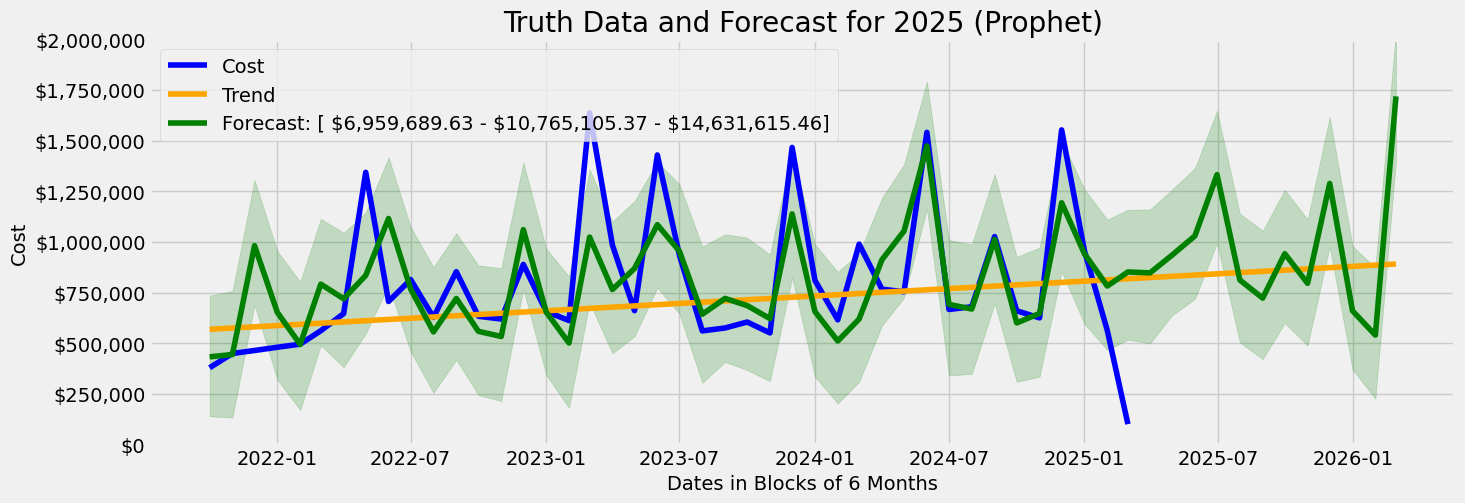

In [7]:
df_ml_p =combined_df.copy()
df_ml_p['Date_str'] = df_ml_p['Year'].apply(lambda x: str(x)) + "-" + df_ml_p['Month No'].apply(lambda x: str(x)) + "-01"
df_ml_p['ds'] = pd.to_datetime(df_ml_p['Date_str'])
df_ml_p = df_ml_p.groupby(['ds']).agg(y=('Cost','sum'))

df_p = pd.DataFrame()

df_p['ds'] = df_ml_p.index
df_p['y'] = df_ml_p['y'].values

model = Prophet()
model.fit(df_p)

# Python
future = model.make_future_dataframe(periods=12, freq='M')   # Create a future DataFrame for 12 months
forecast = model.predict(future)                             # Generate the forecast

yhat_low = forecast.iloc[-13:,:]['yhat_lower'].values
yhat = forecast.iloc[-13:,:]['yhat'].values
yhat_high = forecast.iloc[-13:,:]['yhat_upper'].values


yhat = forecast.iloc[-13:,:]['yhat'].values
fig, ax = plt.subplots(figsize=(15,5))
plt.plot(df_p['ds'], df_p['y'], label='Cost',color='blue')
plt.plot(forecast['ds'], forecast['trend'], label='Trend',color='orange')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast: [ ' + str("${:,.2f}".format(yhat_low[0:-1].sum())) + " - " + str("${:,.2f}".format(yhat[0:-1].sum())) + 
                                                                      " - " + str("${:,.2f}".format(yhat_high[0:-1].sum()))+ ']',color='green')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='green', alpha=0.2)
#plt.plot(forecast['ds'], forecast['yhat_lower'], label='Forecast',color='green', linestyle='--')
#plt.plot(forecast['ds'], forecast['yhat_upper'], label='Forecast',color='green', linestyle='--')
#model.plot(forecast, ax=ax)       # Plot the forecast
#plot(model, forecast)               # Plot the forecast
#plot_components(model, forecast)    # Plot the forecast components
formatter = ticker.ScalarFormatter()
formatter.set_scientific(False)
ax.yaxis.set_major_formatter(formatter)
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['${:,}'.format(int(val)) for val in current_values])
ax.set_title('Truth Data and Forecast for 2025 (Prophet)')
#ax.legend(['Truth Data', 'Prediction','Forecast'], loc='upper left', title='Datesets')
ax.legend(loc='upper left', title='')
ax.set_xlabel("Dates in Blocks of 6 Months", fontsize=14)
ax.set_ylabel("Cost", fontsize=14)
ax.set_ylim(bottom=000000,top=2000000)
plt.show()




# More Analysys -- Lag Plot & Auto Regresion

In [10]:
import datetime as dt
import os
import warnings
from collections import UserDict
from glob import glob

from IPython.display import Image

pd.options.display.float_format = "{:,.2f}".format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")

from pandas.plotting import lag_plot


In [9]:
plt.figure()


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [90]:
df_dl_p =combined_df.copy()
df_dl_p['Date_str'] = df_dl_p['Year'].apply(lambda x: str(x)) + "-" + df_dl_p['Month No'].apply(lambda x: str(x)) + "-01"
df_dl_p['Date'] = pd.to_datetime(df_dl_p['Date_str'])
df_dl_p.set_index('Date')
df_dl_p.index = pd.to_datetime(df_dl_p.index)
df_dl_p = df_dl_p.groupby(['Date']).agg(Cost=('Cost','sum'))


In [91]:
df_dl_p

,Cost
Date,
2021-10-01,"379,435.68"
2021-11-01,"449,911.87"
2021-12-01,"464,683.13"
2022-01-01,"480,684.44"
2022-02-01,"495,868.77"
2022-03-01,"562,230.93"
2022-04-01,"646,850.02"
2022-05-01,"1,344,621.56"
2022-06-01,"706,670.17"


<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

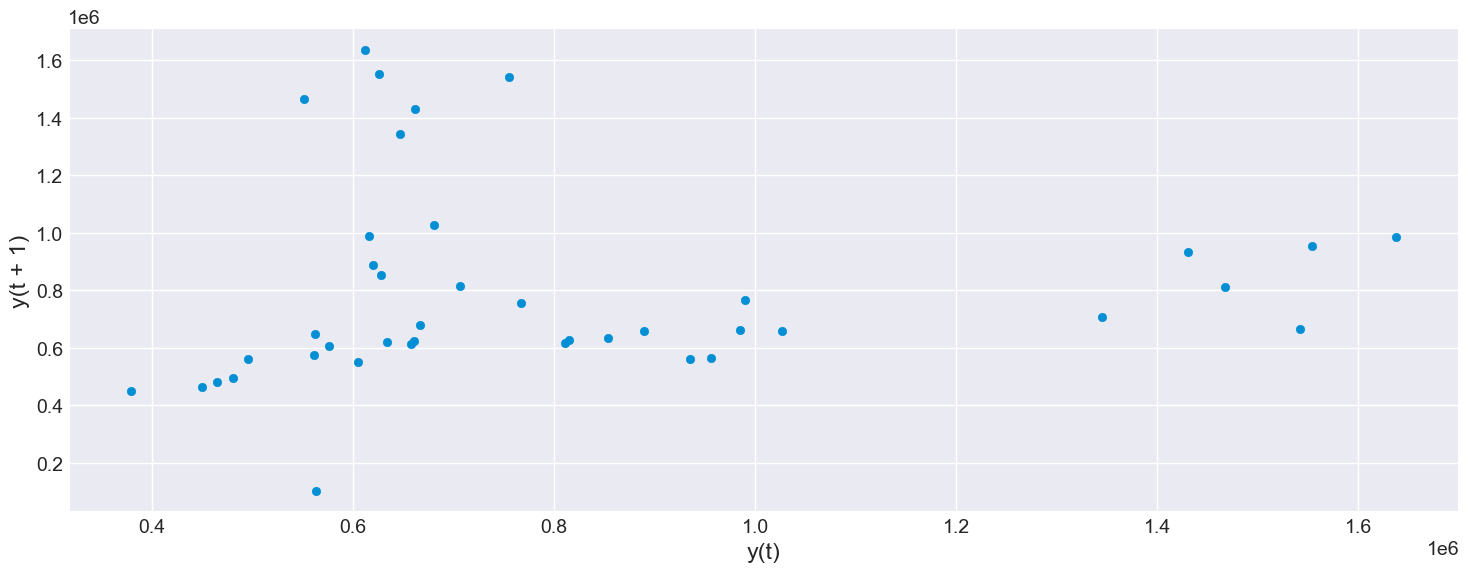

In [92]:
lag_plot(df_dl_p)

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

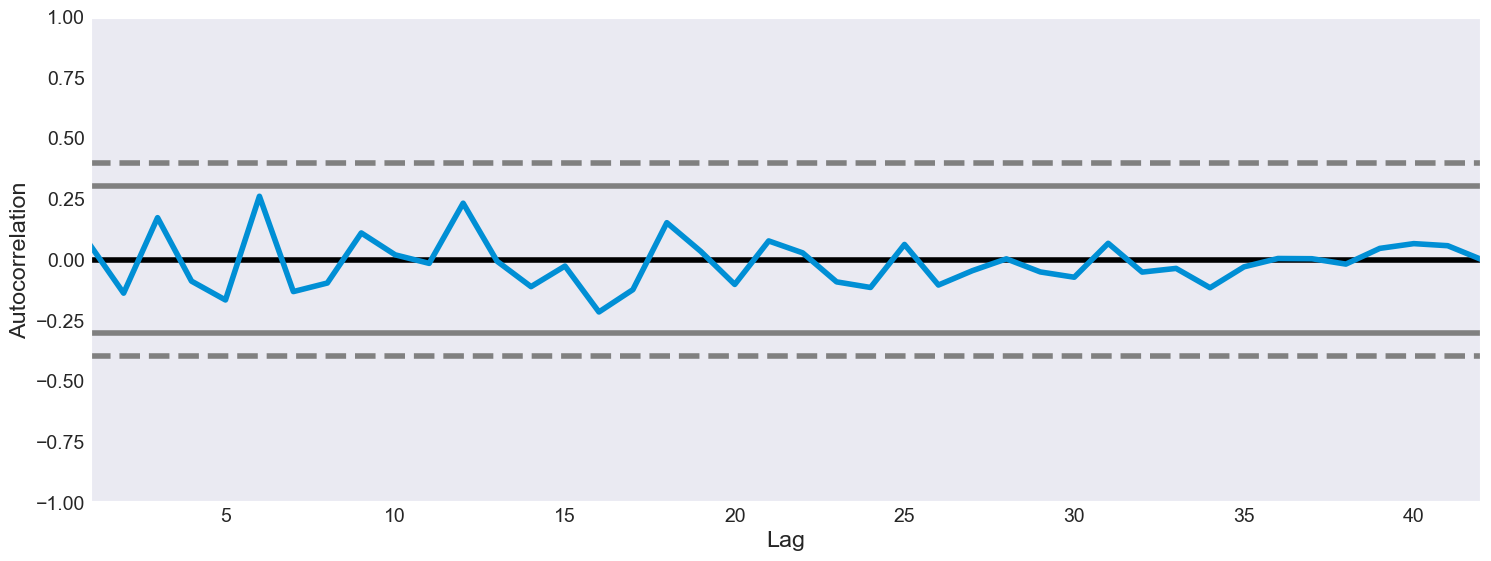

In [93]:
from pandas.plotting import autocorrelation_plot
plt.figure()
autocorrelation_plot(df_dl_p)

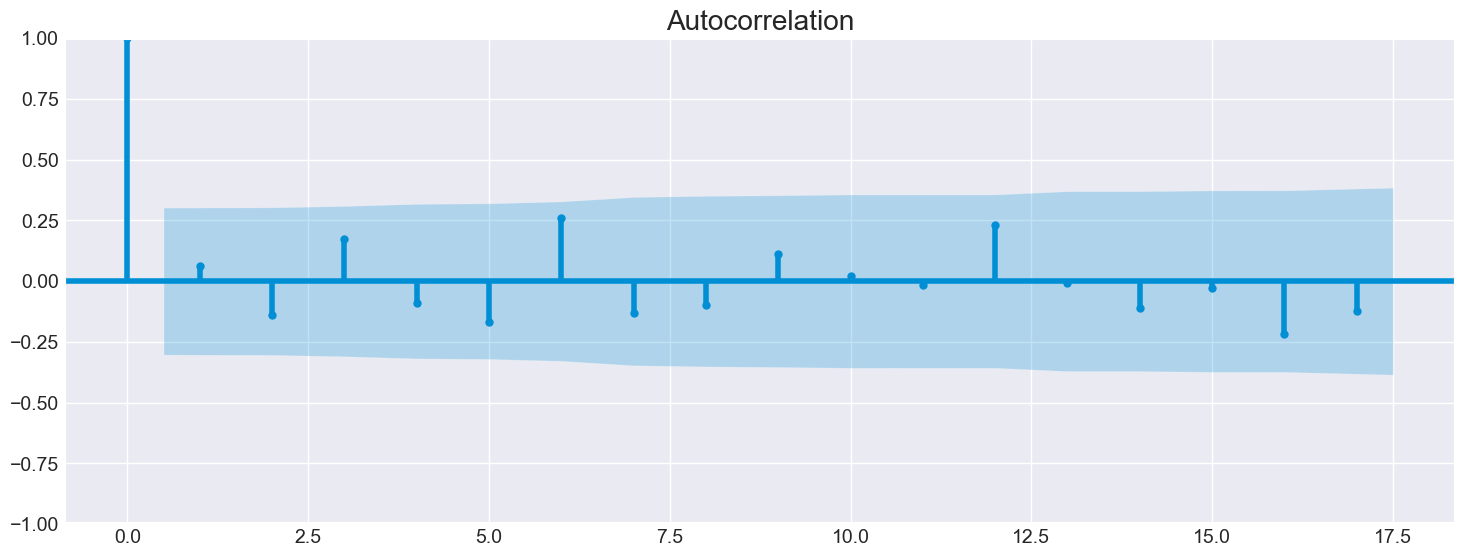

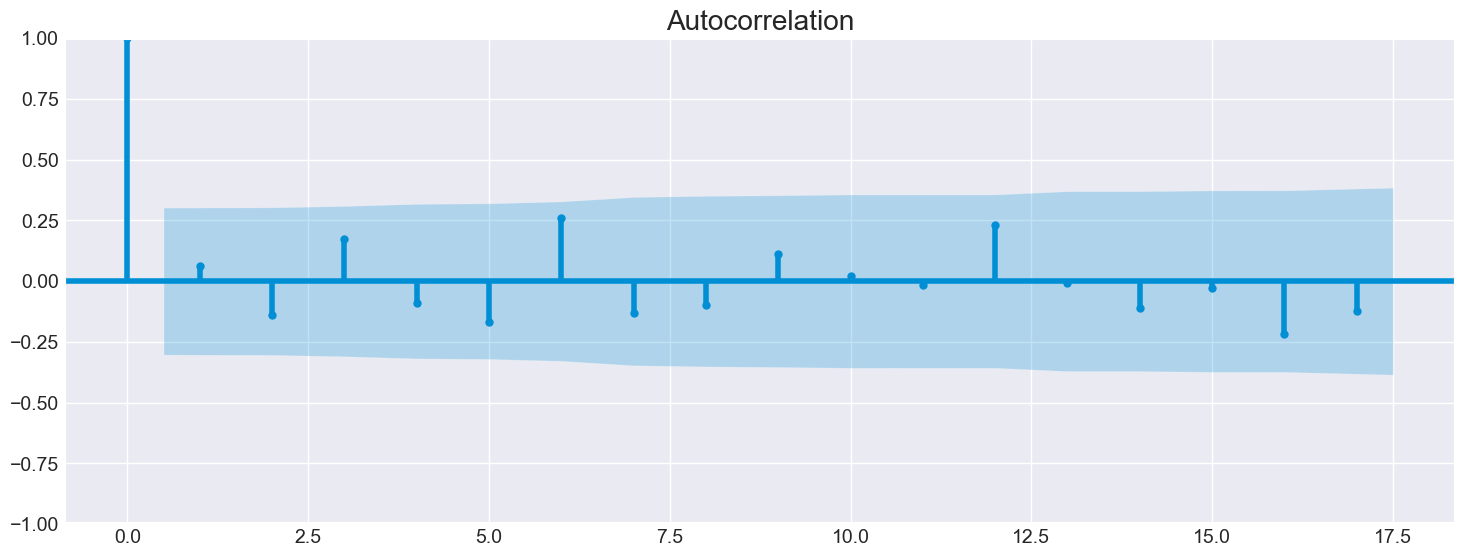

In [94]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df_dl_p)
#pyplot.show()


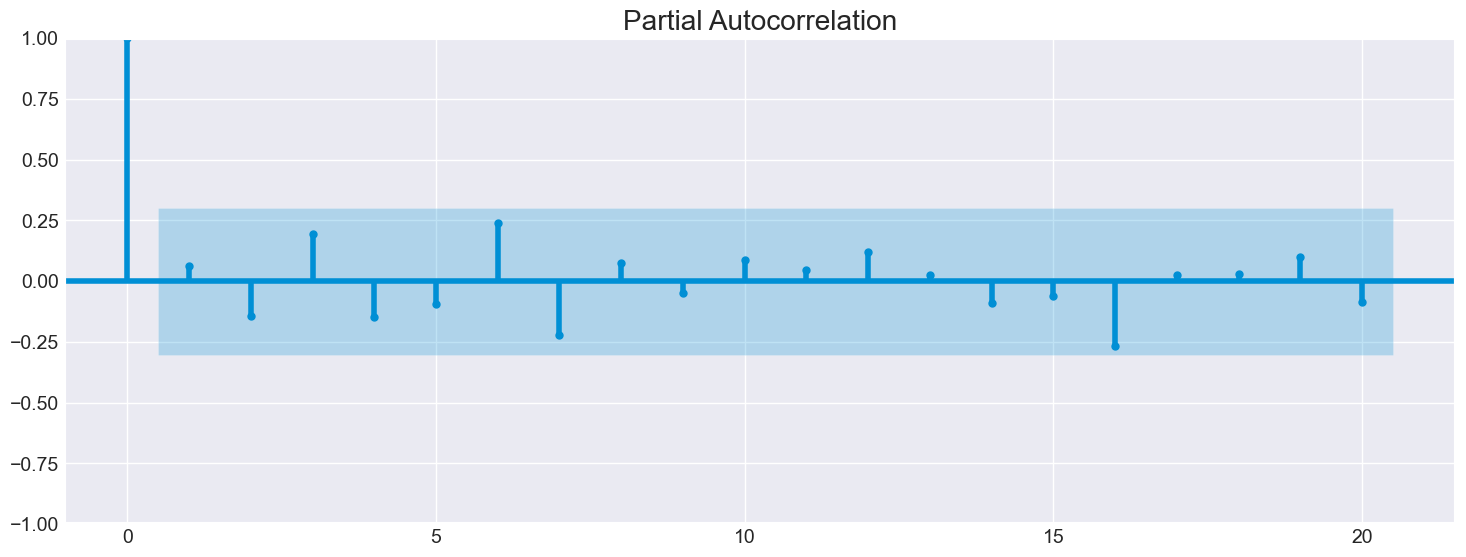

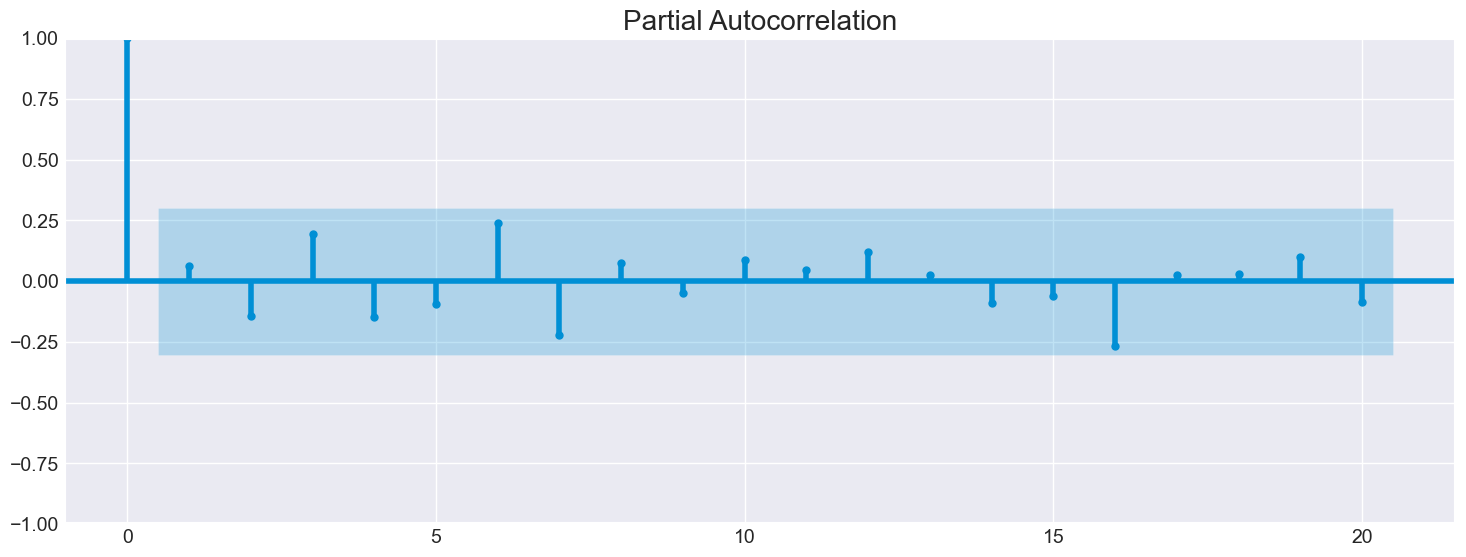

In [95]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df_dl_p, lags=20)

In [96]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.api import acf, pacf, graphics

# Apply the model 
model = AutoReg(df_dl_p, 1)
results = model.fit(cov_type="HC0")
#results = model.fit()
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                   Cost   No. Observations:                   42
Model:                     AutoReg(1)   Log Likelihood                -580.070
Method:               Conditional MLE   S.D. of innovations         337424.912
Date:                Wed, 05 Mar 2025   AIC                           1166.139
Time:                        15:35:31   BIC                           1171.280
Sample:                    11-01-2021   HQIC                          1168.011
                         - 03-01-2025                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.406e+05    1.3e+05      5.694      0.000    4.86e+05    9.96e+05
Cost.L1        0.0677      0.110      0.617      0.537      -0.147       0.283
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           14.7781           +0.0000j           14.7781            0.0000
-----------------------------------------------------------------------------
"""

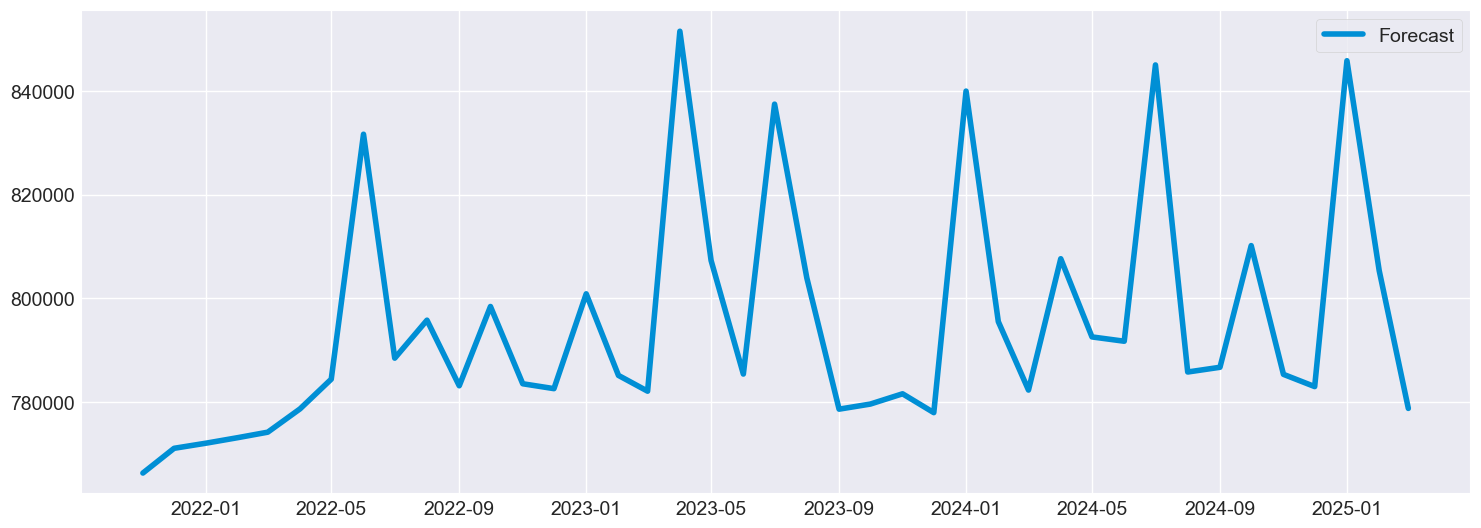

In [97]:
sns.set_style("darkgrid")
pd.plotting.register_matplotlib_converters()

sns.mpl.rc("figure", figsize=(16,6))

figure = results.plot_predict()

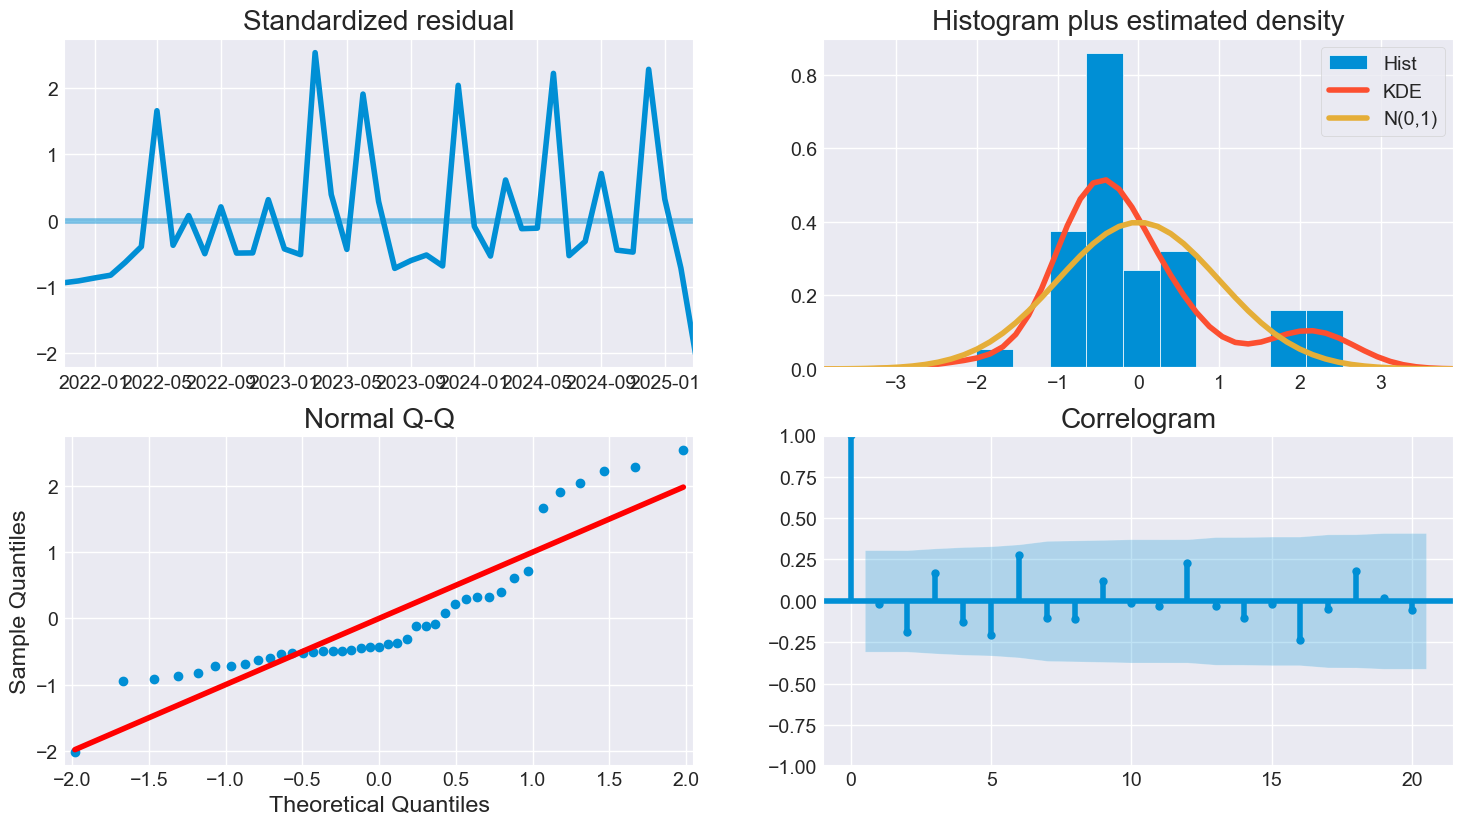

In [98]:
fig = plt.figure(figsize=(16,9))
fig = results.plot_diagnostics(fig=fig, lags=20)

In [99]:
splite_date = '02-01-2024'### (M-D-Y) 12 months before the last day of a full month we are on the calendar year. <March> 
last_date = '03-01-2025' ### <March> and will keep moving as we move on the calendar

In [118]:
train = df_dl_p.loc[df_dl_p.index < splite_date]
test = df_dl_p.loc[(df_dl_p.index >= splite_date) & (df_dl_p.index < last_date)]

In [119]:
print("Data Shape ", df_dl_p.shape)
print("Training Data Shape ", train.shape)
print("Test Data Shape", test.shape)



Data Shape  (42, 1)
Training Data Shape  (28, 1)
Test Data Shape (13, 1)


In [121]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train['Cost'] = scaler.fit_transform(train)
test['Cost'] = scaler.fit_transform(test)


In [122]:
HORIZON = 3

In [130]:
test_shifted = test.copy()
for t in range(1, HORIZON):
    test_shifted['Cost' + str(t)] = test_shifted['Cost'].shift(-t)
test_shifted = test_shifted.dropna(how='any')
test_shifted.head(10)

,Cost,Cost1,Cost2
Date,,,
2024-02-01,0.05,0.43,0.21
2024-03-01,0.43,0.21,0.19
2024-04-01,0.21,0.19,0.99
2024-05-01,0.19,0.99,0.10
2024-06-01,0.99,0.10,0.12
2024-07-01,0.10,0.12,0.47
2024-08-01,0.12,0.47,0.10
2024-09-01,0.47,0.10,0.06
2024-10-01,0.10,0.06,1.00


In [152]:
training_window = 11

train_ts = train['Cost']
test_ts = test_shifted

history = [x for x in train_ts]
history = history[ (-training_window) :]

predictions = list()

for t in range(test_ts.shape[0]):
    model = AutoReg(history, 1)
    model_fit = model.fit()
    yhat = model_fit.forecast(steps=HORIZON)
    predictions.append(yhat)
    obs = list(test_ts.iloc[t])
    history.append(obs[0])
    history.pop(0)
    print(test_ts.index[t])
    print(t + 1, ": predicted =", yhat, "expected =", obs)


2024-02-01 00:00:00
1 : predicted = [0.38 0.38 0.38] expected = [0.0527322565055639, 0.43044637045661727, 0.20558726418064754]
2024-03-01 00:00:00
2 : predicted = [0.36 0.34 0.34] expected = [0.43044637045661727, 0.20558726418064754, 0.1931791544402326]
2024-04-01 00:00:00
3 : predicted = [0.35 0.36 0.36] expected = [0.20558726418064754, 0.1931791544402326, 0.9878956821605382]
2024-05-01 00:00:00
4 : predicted = [0.3 0.3 0.3] expected = [0.1931791544402326, 0.9878956821605382, 0.10466623851628543]
2024-06-01 00:00:00
5 : predicted = [0.29 0.27 0.27] expected = [0.9878956821605382, 0.10466623851628543, 0.11826382600187435]
2024-07-01 00:00:00
6 : predicted = [0.19 0.37 0.33] expected = [0.10466623851628543, 0.11826382600187435, 0.4682103642088633]
2024-08-01 00:00:00
7 : predicted = [0.43 0.32 0.36] expected = [0.11826382600187435, 0.4682103642088633, 0.09793643511728123]
2024-09-01 00:00:00
8 : predicted = [0.41 0.32 0.35] expected = [0.4682103642088633, 0.09793643511728123, 0.06274614